Ce notebook contient l'analyse faite sur l'entièreté des 150 données. L'analyse a ici pris en compte les points obtenus par question.

# Set Up

## Importation des différentes librairies

**Panda.** Librairie permettant de manipuler des tableaux de données avec des étiquettes de variables (colonnes, i.e. pour nous les questions) et d'individus (lignes, i.e. les formulaires ayant été rempli).

**Numpy.** Librairie permettant de faire des calculs scientifique fournissant des fonctions ainsi que des structures de données très performantes de calcul.

**Matplotlib.** Librairie permettant de créer des visuels statiques, animés et interactifs

**Seaborn.** Librairie permettant de visualiser des données, et fournit des interfaces de haut niveau pour dessiner des graphiques statistiques attrayants et informatifs.

In [1]:
import pandas
import numpy
import matplotlib
import seaborn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics 
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OutputCodeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

## Importation du fichier excel et manipulation

Commençons par importer le fichier excel comportant les questions avec réponses selon l'entreprise. Le tableau contenu dans ce fichier sera notre data frame. 

**Définition.** *Data frame.* Un Data frame est une structure de données bidimensionnelle, i.e. les données sont alignées de façon tabulaire en lignes
 et en colonnes.

In [2]:
data_frame = pandas.read_excel('../excel/question.xlsx', sheet_name = 'risk')

Vérifions que l'on a bien 150 lignes, i.e. 150 entreprises, et 18 colonnes, i.e. 16 questions, le total et le nom de l'entreprise.

In [3]:
data_frame.shape

(150, 18)

Retirons les colonnes ne nous intéressant pas, ou contenant des chaines de caractères. Nous ne travaillerons en  effet qu'avec des valeurs numériques.

In [4]:
data_frame = data_frame.drop(columns = ["Unnamed: 0"])

Divisons les réponses de la première question qui sont du type *<span style="color: LightPink;">nb - un secteur</span>*, et ne récupérons que la première partie, i.e. la valeur numérique *<span style="color: LightPink;">nb</span>*.

On affichera finalement le data frame.

In [5]:
data_frame['Q1'] = data_frame['Q1'].str.split(' - ').str[0].astype(int)

data_frame

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Total
0,13,9,2,0,0,2,7,3,0,0,0,0,0,1,0,0,24
1,8,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,4
2,13,9,2,0,0,2,7,3,0,0,1,0,1,1,0,0,26
3,13,9,0,0,0,2,7,3,0,0,0,0,0,1,0,1,23
4,6,9,4,0,1,2,7,3,0,4,0,0,0,1,0,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4,9,0,1,1,2,7,3,0,0,0,0,1,3,0,0,27
146,5,18,0,0,0,2,7,3,0,4,1,1,1,0,0,0,37
147,8,4,2,4,0,0,7,0,1,4,1,1,1,3,1,0,29
148,3,9,4,4,0,0,0,0,0,0,1,1,0,1,0,0,20


Convertissons maintenant la valeur totale en une valeur numérique permettant de représenter le risque. Nous aurons ainsi : 
<ul>
    <li>Low : 0 - représentera les totaux compris entre 0 et 10,</li>
    <li>Medium : 1 - représentera les totaux compris entre 11 et 18,</li>
    <li>High : 2 - représentera les totaux compris entre 19 et 24,</li>
    <li>Critical : 3 - représentera les totaux compris entre 25 et 52.</li>
</ul>

Notons que :

**intervals** représente les intervalles pour lesquelles les totaux doivents correspondre selmon le risque 

**representation** représente l'affiliation du niveau de risque à une valeur numérique

In [6]:
intervals = [0, 10, 18, 24, 52]
representation = [0, 1, 2, 3]
data_frame['Total'] = pandas.cut(data_frame['Total'], bins = intervals, labels = representation)

data_frame['Total'] = data_frame['Total'].astype(int)

data_frame

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Total
0,13,9,2,0,0,2,7,3,0,0,0,0,0,1,0,0,2
1,8,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
2,13,9,2,0,0,2,7,3,0,0,1,0,1,1,0,0,3
3,13,9,0,0,0,2,7,3,0,0,0,0,0,1,0,1,2
4,6,9,4,0,1,2,7,3,0,4,0,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4,9,0,1,1,2,7,3,0,0,0,0,1,3,0,0,3
146,5,18,0,0,0,2,7,3,0,4,1,1,1,0,0,0,3
147,8,4,2,4,0,0,7,0,1,4,1,1,1,3,1,0,3
148,3,9,4,4,0,0,0,0,0,0,1,1,0,1,0,0,2


Assurons nous qu'aucune ligne n'est nulle.

In [7]:
data_frame.isnull().sum()

Q1       0
Q2       0
Q3       0
Q4       0
Q5       0
Q6       0
Q7       0
Q8       0
Q9       0
Q10      0
Q11      0
Q12      0
Q13      0
Q14      0
Q15      0
Q16      0
Total    0
dtype: int64

## Matrice de corrélation

La matrice de corrélation est un outil en probabilité permettant de mesurer le degré de relation linéaire entre chaque paire de variable.

Introduisons deux notions : les variables expliquées et les variables explicatives. 

Les variables expliquées représenteront dans notre cas la colonne Total, i.e. le risque finalement obtenu lors du formulaire. 

Les variables explicatives représenteront l'ensembles des colonnes $Qi$ pour $i \in \{ 1,...,16 \}$.


Ainsi, une partie de l'intérprétation de la matrice de corrélation se fera comme suit :

Au plus le coefficien de la matrice obtenu pour une variable expliquée est proche de zéro, au moins la question a d'importance dans le nombre de points obtenu.

Au plus le coefficien de la matrice obtenu pour une variable expliquée est proche de 1, au plus il y a une forte corrélation entre la variable expliquée et la variable explicative correspondante. 

Si les coefficients de la matrice ne sont pas important entre les variables explicatives, alors il n-y aura pas une grosse corrélation entre elles, et donc on aura très peu de redondance, donc on pourra utiliser toutes nos variables.

<AxesSubplot:>

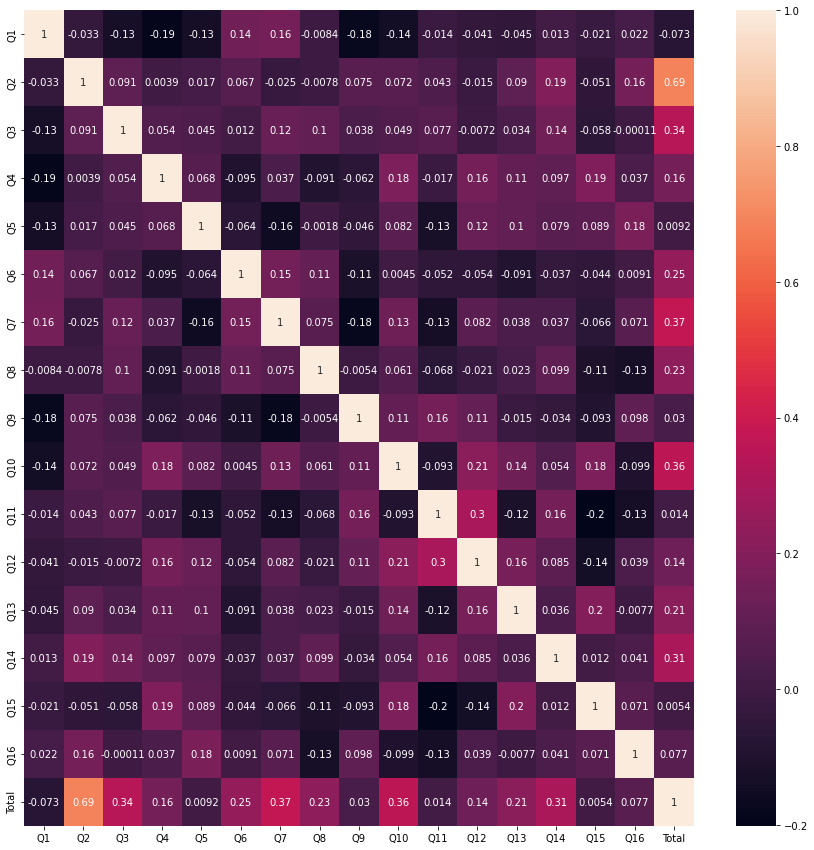

In [8]:
fig = matplotlib.pyplot.figure(figsize = (15,15))
seaborn.heatmap(data_frame.corr(), annot = True)

Nous contatons ici, que la matrice a par exemple pu remarquer que la question 2 avait un fort impact sur le niveau de risque finalement obtenu.

# Machine Learning

Introduisons deux variables, notées *predicted_column* et *training_columns*, représentant respectivement la colonne total, et l'ensemble des questions. 

C'est ainsi, que nous retirerons la colonne Total du data frame, et que nous affecterons à notre variable *predicted_column*. Nous affecterons alors le data frame à la variable *training_columns* sans la colonne Total

In [9]:
training_columns = data_frame.drop(columns = ["Total"])
predicted_column = data_frame['Total']

Pour l'ensemble des modèles j'ai décidé de suivre le principe du 80 - 20 plutôt que le 60 - 40 proposé dans le document envoyé.

Séparons et générons nos différents ensembles d'entrainements et ensembles de tests.

À noter que le *random_state* permet de controler la part aléatoire appliquée aux données avant de pouvoir séparer et générer nos ensemble d'entrainement et de test. 

**Notation.** x représente l'axe des abscisses, donc les inputs, et y représente l'axe des ordonnées donc les outputs. De manière informelle, x est le data frame contenant l'ensemble de questions tandis que y est la colonne des niveaux de risques.

<ul>
    <li>La variable x_train représente la variable input d'entrainement, i.e. les questions qui serviront d'entrainement aux modèles.</li>
    <li>La variable y_train représente la variable output d'entrainement, i.e. les totaux qui serviront de confrimation aux modèles et associés à x_train.</li>
    <li>La variable x_test représente la variable input de test, i.e. les questions qui serviront de test aux modèles.</li>
    <li>La variable x_train représente la variable output de test, i.e. les totaux qui serviront de test aux modèles.</li>
</ul>

Pluis précisément, les variables de test seront les ensemble sur lesquels on testera les entrainements fait par nos modèles.


In [10]:
x_train, x_test, y_train, y_test = train_test_split(training_columns, predicted_column, test_size = 0.2, random_state = 100)

La prochaine étape va être de normaliser nos données, i.e. utiliser la centrée-réduite. Pour se faire, nous appellons la classe StandardScaler().

In [11]:
standard = StandardScaler().fit(x_train)

x_train_standard = standard.transform(x_train)
x_test_standard = standard.transform(x_test)

## Modèle 1 - Classification naïve bayésienne

Nous commençons avec classification naïve bayésienne, i.e. basée sur le théorème de Bayes : Soit $A,B$ deux évènements. Si $\mathbb P(B) \neq 0$, 

$$ \mathbb P_B (A) \,\, = \,\, \frac{\mathbb P (A \, \cap \, B)}{\mathbb P (B)} $$

Nous appelons dans un premier temps la classe GaussianNB( ), puis nous faisons entrer la méthode fit(), qui va nous permettre d'entraîner notre modèle à l'aide des données splitées plus haut, et représentant nos données d'entrainement.

In [12]:
model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

Nous allons maintenant tester notre modèle à l'aide de nos données test, et tenter de faire une prédiction.


In [13]:
y_pred = model.predict(x_test) 

print("Classification naïve bayésienne :", metrics.accuracy_score(y_test, y_pred)*100)

Classification naïve bayésienne : 60.0


### Test du modèle

In [14]:
df_test = pandas.read_excel('../excel/question.xlsx', sheet_name = 'risk')

df_test = df_test.drop(columns = ["Unnamed: 0"])
df_test['Q1'] = df_test['Q1'].str.split(' - ').str[0].astype(int)

intervals = [0, 10, 18, 24, 52]
representation = [0, 1, 2, 3]
df_test['Total'] = pandas.cut(df_test['Total'], bins = intervals, labels = representation)

df_test['Total'] = df_test['Total'].astype(int)

training_columns_test = df_test.drop(columns = ["Total"])
predicted_column_test = df_test['Total']

y_pred = model.predict(training_columns_test) 
df_test['Predictions'] = y_pred

df_test.to_excel("Predictions_GaussianNB_1.xlsx")

# Modèle 2 - One-vs-the-rest

Nous commençons par appeler la classe OneVsTheRestClassifier, puis nous passons en paramètre la classe LinearSVC.

Étant donné que l'on va passer LinearSVC en paramètre, il peut s'avérer utile de déterminer la meilleure mise en scène possible, et allons donc tester chacun des paramètres, pour en faire ressortir la meilleure configuration.

Introduisons un dictionnaire permettant de faire varier les paramètres souhaités.

Notons que l'on ajoute devant chaque paramètre *<span style="color: LightPink;">estimator__</span>*. Cela nous permettra de déterminer la meilleur configuration concernant la clase LinearSVC et non la clase OneVsRestClassifier.

In [15]:
parameters = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__loss' : ['hinge', 'squared_hinge'],
    'estimator__dual' : [True, False],
    'estimator__C' : [i for i in numpy.arange(1e-5, 100, 10)],
    'estimator__random_state' : [0],
    'estimator__max_iter' : [i for i in range(500, 2500, 100)]
}

Nous allons maintenant introduire la classe GridSearchCV(), qui va nous permettre de détérminer la meilleure configuration.

Nous utiliserons le paramètre *<span style="color: LightPink;">cv</span>*. Il nous permettra d'éviter le sur - entraînement de  notre modèle.

In [16]:
ovr_model = GridSearchCV(
    OneVsRestClassifier(LinearSVC()), 
    parameters,
    cv = 5, 
    scoring = 'accuracy'
)

Nous appelons ensuite la méthode fit qui nous permettra d'entrainer le modèle, et faisons une prediction.

> Lorsque le code est lancé, cela peut prendre quelques temps car le programme va tester toutes les options pour en déterminer la meilleure

In [17]:
# On igniore les warnings générer lors de la détermination
warnings.filterwarnings('ignore')

ovr_model.fit(x_train_standard, y_train)

print("\nMeilleure configuration pour LinearSVC :\n", ovr_model.best_params_)

y_pred = ovr_model.predict(x_test_standard)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Meilleure configuration pour LinearSVC :
 {'estimator__C': 50.00001, 'estimator__dual': True, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1100, 'estimator__penalty': 'l2', 'estimator__random_state': 0}

Performance du modèle : 80.0


### Test du modèle

In [18]:
df_test = pandas.read_excel('../excel/question.xlsx', sheet_name = 'risk')

df_test = df_test.drop(columns = ["Unnamed: 0"])
df_test['Q1'] = df_test['Q1'].str.split(' - ').str[0].astype(int)

intervals = [0, 10, 18, 24, 52]
representation = [0, 1, 2, 3]
df_test['Total'] = pandas.cut(df_test['Total'], bins = intervals, labels = representation)

df_test['Total'] = df_test['Total'].astype(int)

training_columns_test = df_test.drop(columns = ["Total"])
predicted_column_test = df_test['Total']

y_pred = ovr_model.predict(training_columns_test) 
df_test['Predictions'] = y_pred

df_test.to_excel("Predictions_OneVsRestClassifier_1.xlsx")

# Modèle 3 - Output-code-classifier

Nous commençons par appeler la classe OutputCodeClassifier, puis nous passons en paramètre la classe LinearSVC.

Étant donné que l'on va passer LinearSVC en paramètre, il peut s'avérer utile de déterminer la meilleure mise en scène possible, et allons donc tester chacun des paramètres, pour en faire ressortir la meilleure configuration.

Introduisons un dictionnaire permettant de faire varier les paramètres souhaités.

Notons que l'on ajoute devant chaque paramètre *<span style="color: LightPink;">estimator__</span>*. Cela nous permettra de déterminer la meilleur configuration concernant la clase LinearSVC et non la clase OutputCodeClassifier.

In [19]:
parameters = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__loss' : ['hinge', 'squared_hinge'],
    'estimator__dual' : [True, False],
    'estimator__C' : [i for i in numpy.arange(1e-5, 100, 10)],
    'estimator__random_state' : [0],
    'estimator__max_iter' : [i for i in range(500, 2500, 100)]
}

Nous allons maintenant introduire la classe GridSearchCV(), qui va nous permettre de détérminer la meilleure configuration.

Nous utiliserons le paramètre *<span style="color: LightPink;">cv</span>*. Il nous permettra d'éviter le sur - entraînement de  notre modèle.

In [20]:
ocd_model = GridSearchCV(
    OutputCodeClassifier(LinearSVC()), 
    parameters,
    cv = 5, 
    scoring = 'accuracy'
)

Nous appelons ensuite la méthode fit qui nous permettra d'entrainer le modèle, et faisons une prediction.

> Lorsque le code est lancé, cela peut prendre quelques temps car le programme va tester toutes les options pour en déterminer la meilleure

In [21]:
# On igniore les warnings générer lors de la détermination
warnings.filterwarnings('ignore')

ocd_model.fit(x_train_standard, y_train)

print("\nMeilleure configuration pour LinearSVC :\n", ocd_model.best_params_)

y_pred = ocd_model.predict(x_test_standard)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Meilleure configuration pour LinearSVC :
 {'estimator__C': 60.00001, 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1400, 'estimator__penalty': 'l1', 'estimator__random_state': 0}

Performance du modèle : 60.0


### Test du modèle

In [22]:
df_test = pandas.read_excel('../excel/question.xlsx', sheet_name = 'risk')

df_test = df_test.drop(columns = ["Unnamed: 0"])
df_test['Q1'] = df_test['Q1'].str.split(' - ').str[0].astype(int)

intervals = [0, 10, 18, 24, 52]
representation = [0, 1, 2, 3]
df_test['Total'] = pandas.cut(df_test['Total'], bins = intervals, labels = representation)

df_test['Total'] = df_test['Total'].astype(int)

training_columns_test = df_test.drop(columns = ["Total"])
predicted_column_test = df_test['Total']

y_pred = ocd_model.predict(training_columns_test) 
df_test['Predictions'] = y_pred

df_test.to_excel("Predictions_OutputCodeClassifier_1.xlsx")

# Modèle 4 - Regression logistic

Le modèle de regression logistique permet d'associer à un verteur de variables aléatoires $ (X_1,\ldots ,X_k)$, une variable une variable aléatoire binomiale, notée $Y$. 

Nous allons appeler la classe LogisticRegression(). Cette classe prend différent paramètre, et peut améliorer le résultat selon ce qui lui est défini, il peut s'avérer utile de déterminer la meilleure mise en scène possible, et nous allons donc tester chacun des paramètres, pour en faire ressortir la meilleure configuration.

Introduisons un dictionnaire permettant de faire varier les paramètres souhaités.

In [23]:
parameters = {
    'penalty' : ['l1', 'l2'],
    'dual' : [True, False],
    'C' : [i for i in numpy.arange(1e-5, 100, 10)],
    'fit_intercept' : [True, False],
    'random_state' : [0],
    'max_iter' : [i for i in range(500, 2000, 100)]
}

Nous allons maintenant introduire la classe GridSearchCV(), qui va nous permettre de détérminer la meilleure configuration.

Nous utiliserons le paramètre *<span style="color: LightPink;">cv</span>*. Il nous permettra d'éviter le sur - entraînement de  notre modèle.

In [24]:
lr_model = GridSearchCV(
    LogisticRegression(), 
    parameters,
    cv = 5, 
    scoring = 'accuracy'
)

Nous appelons ensuite la méthode fit qui nous permettra d'entrainer le modèle, et faisons une prediction.

> Lorsque le code est lancé, cela peut prendre quelques temps car le programme va tester toutes les options pour en déterminer la meilleure

In [25]:
# On igniore les warnings générer lors de la détermination
warnings.filterwarnings('ignore')

lr_model.fit(x_train_standard, y_train)

print("\nMeilleure configuration pour LinearSVC :\n", lr_model.best_params_)

y_pred = lr_model.predict(x_test_standard)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Meilleure configuration pour LinearSVC :
 {'C': 30.00001, 'dual': False, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l2', 'random_state': 0}

Performance du modèle : 83.33333333333334


### Test du modèle

In [26]:
df_test = pandas.read_excel('../excel/question.xlsx', sheet_name = 'risk')

df_test = df_test.drop(columns = ["Unnamed: 0"])
df_test['Q1'] = df_test['Q1'].str.split(' - ').str[0].astype(int)

intervals = [0, 10, 18, 24, 52]
representation = [0, 1, 2, 3]
df_test['Total'] = pandas.cut(df_test['Total'], bins = intervals, labels = representation)

df_test['Total'] = df_test['Total'].astype(int)

training_columns_test = df_test.drop(columns = ["Total"])
predicted_column_test = df_test['Total']

y_pred = lr_model.predict(training_columns_test) 
df_test['Predictions'] = y_pred

df_test.to_excel("Predictions_LogisticRegression_1.xlsx")

# Modèle 5 - Dummy Classifier

Ce modèle permet de faire des prédictions basées sur l'aléatoire en ignorant les inputs. Il nous servira de comparaison aux autres modèles, afin de voir si on est sur la bonne longueur d'onde.

Nous allons appeler la classe DummyClassifier(). Cette classe prend différente stratégie. Nous testerons donc ces stratégies.

Commençons par la stratégie *<span style="color: LightPink;">most_frequent</span>*.

In [27]:
dm_model = DummyClassifier(strategy = "most_frequent", random_state = 0)

dm_model.fit(x_train, y_train)

y_pred = dm_model.predict(x_test)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Performance du modèle : 50.0


Utilisons la stratégie *<span style="color: LightPink;">prior</span>*.

In [28]:
dm_model = DummyClassifier(strategy = "prior", random_state = 0)

dm_model.fit(x_train, y_train)

y_pred = dm_model.predict(x_test)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Performance du modèle : 50.0


Utilisons la stratégie *<span style="color: LightPink;">stratified</span>*.

In [29]:
dm_model = DummyClassifier(strategy = "stratified", random_state = 0)

dm_model.fit(x_train, y_train)

y_pred = dm_model.predict(x_test)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Performance du modèle : 30.0


Utilisons la stratégie *<span style="color: LightPink;">uniform</span>*.

In [30]:
dm_model = DummyClassifier(strategy = "uniform", random_state = 0)

dm_model.fit(x_train, y_train)

y_pred = dm_model.predict(x_test)

print("\nPerformance du modèle :", accuracy_score(y_test, y_pred) * 100)


Performance du modèle : 36.666666666666664
